<a href="https://colab.research.google.com/github/Flukasiew/ColabExperiments/blob/master/DatasetGeneration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Znalazlem dwie interesujace Biblioteki dotyczace generowanie muzyki w roznych formatach.

In [1]:
!pip install mingus 
!pip install python-ly

In [1]:
import mingus.extra.lilypond as LilyPond
from mingus.containers.bar import Bar
b = Bar()
b + "C"
b + "E"
b + "G"
b + "B"
bar = LilyPond.from_Bar(b)
LilyPond.to_png(bar, "Users\my_first_bar") # it can here create png 

Executing: lilypond -fpng -o "Users\my_first_bar" "Users\my_first_bar.ly"


True

Problem to brak programu  w colabie lilypond ale spokojnie jest do zrobienia.

mingus pozwala na generowanie z takiego ciagu zarowno midi jak i png.

python-ly pozwala generowac music-xml z LilyPond stringow

Wiec jesli zdecydujemy sie na zakres dzwiekow ktory chcemy miec w zbiorze moge zabrac sie za pisanie jakiegos generatora a potem "filtrow" na te png 

PRÓBAAAA

In [2]:
# Zabawy Janusza

## Generator LilyPondów

In [3]:
import mingus.core.notes as notes
from mingus.containers import Note, NoteContainer, Bar, Track, Instrument, Composition
import random
import mingus.extra.lilypond as LilyPond
import re

In [297]:
#stałe globalne

allNotesM = ["A-3", "B-3", "C-4", "D-4","E-4", "F-4", "G-4", "A-4", "B-4", "C-5", "D-5", "E-5", "F-5", "G-5", "A-5", "B-5", "C-6" ]
lenAllNotesM = len(allNotesM)
largestInterval = 4
pOfChromatics=.05

quarterGroupOptions16 = [[1],[1],[1],[1],[1],[1],[1],[1],[1],[1],[1],[.5,.5],[.5,.5],[.5,.5],[.5,.5], [.5, .5], [.25, .25, .5], [.5, .25, .25],[.25, .25, .25, .25]]
quarterGroupOptions8 = [[1],[1],[0.5,0.5]]
bar4GroupOptions = [[4],[4], [2,2], [2,1,1],[2,1,1],[1,1,2],[1,1,2],[1,1,1,1],[1,1,1,1]]
bar3GroupOptions = [[2,1],[1,2],[1,1,1]]

pOfRests=.15

noteSymbols = ["\marcato", "\\stopped", "\\tenuto", "\staccatissimo", "\\accent", "\staccato", "\portato","^\\ppp", "^\\pp", "^\\p", "^\mp", "^\mf", "^\\f", "^\\ff", "^\\fff", "^\mp", "^\\sf", "^\\sfz","_\\ppp", "_\\pp", "_\\p", "_\mp", "_\mf", "_\\f", "_\\ff", "_\\fff", "_\mp", "_\sf", "_\sfz"]

In [294]:
for symbol in noteSymbols:
    print(symbol)

\marcato
\stopped
\tenuto
\staccatissimo
\accent
\staccato
\portato
^\ppp
^\pp
^\p
^\mp
^\mf
^\f
^\ff
^\fff
^\mp
^\sf
^\sfz
_\ppp
_\pp
_\p
_\mp
_\mf
_\f
_\ff
_\fff
_\mp
_\sf
_\sfz


### Generowanie melodii

In [5]:
# jeśli before=-1 -> pierwsza nuta
def newNoteIndexM(before):
    if before==-1:
        return random.randint(0,lenAllNotesM-1)
    
    if before<largestInterval:
        return random.randint(0,2*largestInterval)
    
    if before>lenAllNotesM-largestInterval-1:
        return random.randint(lenAllNotesM-2*largestInterval, lenAllNotesM-1)
        
    return random.randint(before-largestInterval,before+largestInterval-1)

In [6]:
# dla length>0
def newNoteIndexListM(length):
    prev = newNoteIndexM(-1)
    melody = [prev]
    for i in range(1,length):
        prev = newNoteIndexM(prev)
        melody.append(prev)
    return melody

In [7]:
def newMelodyWithoutChromatics(length):
    return [Note(allNotesM[a]) for a in newNoteIndexListM(length)]

In [8]:
newMelodyWithoutChromatics(10)

['C-6', 'E-5', 'C-5', 'A-4', 'B-4', 'C-5', 'G-4', 'E-4', 'D-4', 'A-4']

In [9]:
def newMelody(length):
    melody = []   
    for index in newNoteIndexListM(length):
        k = random.random()
        note = Note(allNotesM[index])
        if k<pOfChromatics:
            note.augment()
        elif k>1-pOfChromatics:
            note.diminish()
        melody.append(note)
    return melody

In [10]:
newMelody(10)

['C-6', 'G-5', 'G-5', 'B-5', 'A-5', 'C-5', 'B-4', 'B-4', 'C-5', 'B-4']

### Generowanie rytmu

In [11]:
def newQuarterGroup(with16):
    if with16:
        return random.choice(quarterGroupOptions16)
    else:
        return random.choice(quarterGroupOptions8)

In [12]:
newQuarterGroup(True)

[1]

In [13]:
def newBarRhythm(beats,with16):
    finalRhythm=[]
    if beats==4:
        rhythm = random.choice(bar4GroupOptions)
    if beats==3:
        rhythm = random.choice(bar3GroupOptions)
    
    for ii in range(len(rhythm)):
        if rhythm[ii]==1:
            finalRhythm.extend(newQuarterGroup(with16))
        else:
            finalRhythm.append(rhythm[ii])
    return finalRhythm

In [14]:
print('4/4 Bar: ', newBarRhythm(4,True))
print('3/4 Bar: ', newBarRhythm(3,False))

4/4 Bar:  [4]
3/4 Bar:  [1, 1, 1]


### Generowanie ścieżki

In [15]:
# NewTrack(liczba_uderzeń_w_takcie, liczba_taktów, czy_z_chromatyką, czy_z_16)
# zwraca krotkę z trackiem i liczbą nut
def NewTrack(beats,count,withChromatics,with16):
    track=Track(Instrument())
    rhythms=[]
    noOfNotes=0
    melodyCount=0
    
    for ii in range(count):
        rhythms.append(newBarRhythm(beats,with16))
        noOfNotes+=len(rhythms[ii])
    
    if withChromatics:
        melody = newMelody(noOfNotes)
    else:
        melody = newMelodyWithoutChromatics(noOfNotes)
    
    for rhythm in rhythms:
        b = Bar('C',(beats,4))
        for note in rhythm:
            k=random.random()
            if k>pOfRests:
                b.place_notes(melody[melodyCount], 4/note)
            else:
                b.place_notes(None, 4/note)
            melodyCount+=1
        track+b
    return (track,melodyCount)

In [16]:
NewTrack(4,2,True,True)

([Instrument ['C-0' - 'C-8'], [[[0.0, 8.0, ['A-4']], [0.125, 8.0, ['E-4']], [0.25, 8.0, ['E-4']], [0.375, 8.0, ['F-4']], [0.5, 16.0, ['B-3']], [0.5625, 16.0, ['Eb-4']], [0.625, 8.0, ['F-4']], [0.75, 4.0, ['B-3']]], [[0.0, 2.0, ['F-4']], [0.5, 4.0, None], [0.75, 4.0, ['A-4']]]]],
 11)

### Generowanie notacji w formacie LilyPond

In [17]:
track, count = NewTrack(4,10,False,True)
lp = LilyPond.from_Track(track)
print(lp)

{ { a''1 } { c'''1 } { d''2 g''16 f''16 f''8 a''8 e''8 } { d''4 f''4 r2 } { c'''2 r2 } { e''2 a''4 c''8 a'8 } { f'8 r8 b'8 b'16 f'16 d'8 b8 f'4 } { f'2 r2 } { c'1 } { e'2 g'4 f'8 b'8 } }


In [18]:
#ładniejsza funkcja do obsługi generatora - zwraca stringa od razu

def GenRegularLily(time, bars, withChrom, with16, withSymbols):
    track,count = NewTrack(time, bars, withChrom, with16)
    lily=LilyPond.from_Track(track)
    
    return lily
    

In [19]:
GenRegularLily(4,10,False,True, False)

"{ { d''2 g''2 } { a''4 b''8 a''16 r16 d''2 } { a'1 } { b'2 c''2 } { g'4 b'4 g'8 b'8 a'4 } { d'4 b4 f'2 } { f'2 e'2 } { c'16 a16 c'8 e'4 b4 a'8 f'8 } { b'2 f'8 r8 c''8 f''8 } { g''4 f''4 e''2 } }"

### Generowanie potrójnego lilyPonda

In [320]:
noteSymbols = ["\\\\marcato", "\\\\stopped", "\\\\tenuto", "\\\\staccatissimo", "\\\\accent", "\\\\staccato", "\\\\portato","^\\\\ppp", "^\\\\pp", "^\\\\p", "^\\\\mp", "^\\\\mf", "^\\\\f", "^\\\\ff", "^\\\\fff", "^\\\\mp", "^\\\\sf", "^\\\\sfz","_\\\\ppp", "_\\\\pp", "_\\\\p", "_\\\\mp", "_\\\\mf", "_\\\\f", "_\\\\ff", "_\\\\fff", "_\\\\mp", "_\\\\sf", "_\\\\sfz"]

In [484]:
from re import findall
lp = GenRegularLily(4,10,False,True, True)
main_pattern = r" [a-z]'*\d "
occurances = findall(main_pattern,lp)
count = random.randint(len(occurances)//4,len(occurances)//2)
to_replace = random.sample(occurances, k = count)
new_notes = [note[:-1]+random.choice(noteSymbols)+" " for note in to_replace]
for pattern,replacement in zip(to_replace,new_notes):
    print(pattern,replacement)
    lp = re.sub(pattern,replacement,lp,count=1)
    
print(count, to_replace)
print(new_notes)
print(lp)

 a'4   a'4\\stopped 
 a'2   a'2^\\ff 
 a'1   a'1_\\ff 
 a'4   a'4\\marcato 
 a'1   a'1^\\mp 
 r4   r4^\\sfz 
 b8   b8_\\mp 
7 [" a'4 ", " a'2 ", " a'1 ", " a'4 ", " a'1 ", ' r4 ', ' b8 ']
[" a'4\\\\stopped ", " a'2^\\\\ff ", " a'1_\\\\ff ", " a'4\\\\marcato ", " a'1^\\\\mp ", ' r4^\\\\sfz ', ' b8_\\\\mp ']
{ { e''2 e''4 b'8 c''8 } { a'4\stopped d'4 a'2^\ff } { a'1_\ff } { f'8 d'8 b8_\mp a'8 d''2 } { a'2 d''8 c''16 g'16 b'8 a'16 f'16 } { b'2 a'4\marcato a'4 } { r4^\sfz d'4 b2 } { b'2 a'16 r16 g'8 b'4 } { a'1^\mp } { a'4 d''4 a'2 } }


In [499]:
def GenSingleLily(time, bars, withChrom, with16):
    delete_clef_string = " \n \override Staff.Clef.color = #white \n \override Staff.Clef.layer = #-1"
    delete_time_string = " \n \override Staff.TimeSignature.color = #white \n \override Staff.TimeSignature.layer = #-1"
    track,count = NewTrack(time, bars, withChrom, with16)
    ground_lp = LilyPond.from_Track(track)
    lp = CleanTrack(ground_lp)
    main_pattern = r" [a-z]'*\d "
    occurances = findall(main_pattern,lp)
    count = random.randint(len(occurances)//4,len(occurances)//2)
    to_replace = random.sample(occurances, k = count)
    new_notes = [note[:-1]+random.choice(noteSymbols)+" " for note in to_replace]
    for pattern,replacement in zip(to_replace,new_notes):
        lp = re.sub(pattern,replacement,lp,count=1)
    return lp, ground_lp
    

In [490]:
def GenTripleLily(time, bars, withChrom, with16):
    lp, ground_lp = GenSingleLily(time, bars, withChrom, with16)
    return " \\new PianoStaff \with { \override StaffGrouper.staff-staff-spacing = #'((basic-distance . 10) (padding . 10)) } << \\new Staff " + lp + " \\new Staff " + lp + " \\new Staff " + lp +" >>", ground_lp
    

In [434]:
#zwraca krotkę z stringiem do generowania potrójnego obrazu i stringiem do datasetu
def GenTripleLily(time, bars, withChrom, with16):
    delete_clef_string = " \n \override Staff.Clef.color = #white \n \override Staff.Clef.layer = #-1"
    delete_time_string = " \n \override Staff.TimeSignature.color = #white \n \override Staff.TimeSignature.layer = #-1"
    track,count = NewTrack(time, bars, withChrom, with16)
    ground_lp = LilyPond.from_Track(track)
    lp = CleanTrack(ground_lp)
    main_pattern = r" [a-z]'*\d "
    occurances = findall(main_pattern,lp)
    count = random.randint(0,len(occurances))
    to_replace = random.sample(occurances, k = count)
    new_notes = [note[:-1]+random.choice(noteSymbols)+" " for note in to_replace]
    for pattern,replacement in zip(to_replace,new_notes):
        lp = re.sub(pattern,replacement,lp,count=1)
    return " \\new PianoStaff \with { \override StaffGrouper.staff-staff-spacing = #'((basic-distance . 10) (padding . 10)) } << \\new Staff " + lp + " \\new Staff " + lp + " \\new Staff " + lp +" >>", ground_lp


In [435]:
print(GenTripleLily(4,10,False,True)[0])

 \new PianoStaff \with { \override StaffGrouper.staff-staff-spacing = #'((basic-distance . 10) (padding . 10)) } << \new Staff { 
 \override Staff.Clef.color = #white 
 \override Staff.Clef.layer = #-1 
 \override Staff.TimeSignature.color = #white 
 \override Staff.TimeSignature.layer = #-1 { r8\portato c'16 r16 e'8^\mp c'8 a4 a'16 b'16 r8 } { b'4 f'4 d'2 } { r1 } { a'1 } { f'8 f'16 r16 f'4 r4 f'8 b16 d'16 } { c'1 } { a'2 r8 a'8 e'4 } { e'4 a'4 g'4_\mf f'4 } { r16 d''16 b'16 r16 b'16 c''16 f''8 a''2 } { g''2 d''2 } } \new Staff { 
 \override Staff.Clef.color = #white 
 \override Staff.Clef.layer = #-1 
 \override Staff.TimeSignature.color = #white 
 \override Staff.TimeSignature.layer = #-1 { r8\portato c'16 r16 e'8^\mp c'8 a4 a'16 b'16 r8 } { b'4 f'4 d'2 } { r1 } { a'1 } { f'8 f'16 r16 f'4 r4 f'8 b16 d'16 } { c'1 } { a'2 r8 a'8 e'4 } { e'4 a'4 g'4_\mf f'4 } { r16 d''16 b'16 r16 b'16 c''16 f''8 a''2 } { g''2 d''2 } } \new Staff { 
 \override Staff.Clef.color = #white 
 \override Staff

## No clef or time in the picture

In [22]:
delete_clef_string = " \n \override Staff.Clef.color = #white \n \override Staff.Clef.layer = #-1"
delete_time_string = " \n \override Staff.TimeSignature.color = #white \n \override Staff.TimeSignature.layer = #-1"

def CleanTrack(track):
    track = track[0] + delete_clef_string + delete_time_string+ track[1:]
    return track

## Generate Cropped png

In [48]:
import subprocess
import os

def GenerateCropped(ly_string, filename, command='-fpng'):
    """Generates cropped PNG it is slightly changed version of minugs save_string_and_execute_LilyPond function"""
    ly_string = '\\version "2.10.33"\n' + ly_string
    if filename[-4] in ['.pdf' or '.png']:
        filename = filename[:-4]
    try:
        f = open(filename + '.ly', 'w')
        f.write(ly_string)
        f.close()
    except:
        return False
    command = 'lilypond -dresolution=300 -dpreview %s -o "%s" "%s.ly"' % (command, filename, filename)
    print('Executing: %s' % command)
    p = subprocess.Popen(command, shell=True).wait()
    os.remove(filename + '.ly')
    return True

In [24]:
track = NewTrack(4,6,False,False)
lp = LilyPond.from_Track(track)
print(lp)
c_track = CleanTrack(lp)

False


TypeError: 'bool' object is not subscriptable

In [25]:
GenerateCropped(c_track,"my_first_track")

NameError: name 'c_track' is not defined

In [49]:
from PIL import Image

def imgConvert(from_name, to_name):
    im = Image.open(from_name)
    rgb_im = im.convert('RGB')
    rgb_im.save(to_name)

## Convert to jpg

In [50]:
imgConvert("my_first_track.preview.png", "track.jpg")

FileNotFoundError: [Errno 2] No such file or directory: 'my_first_track.preview.png'

## Transformations

In [27]:
from functools import reduce
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [28]:
# Construct 3D rotation matrix when rotations around x,y,z axes are specified 
def construct_RotationMatrixHomogenous(rotation_angles):
    assert(type(rotation_angles)==list and len(rotation_angles)==3)
    RH = np.eye(4,4)
    cv2.Rodrigues(np.array(rotation_angles), RH[0:3, 0:3])
    return RH

In [29]:
# https://en.wikipedia.org/wiki/Rotation_matrix
def getRotationMatrixManual(rotation_angles):
    
    rotation_angles = [ np.deg2rad(x) for x in rotation_angles]
    
    phi         = rotation_angles[0] # around x
    gamma       = rotation_angles[1] # around y
    theta       = rotation_angles[2] # around z
    
    # X rotation
    Rphi        = np.eye(4,4)
    sp          = np.sin(phi)
    cp          = np.cos(phi)
    Rphi[1,1]   = cp
    Rphi[2,2]   = Rphi[1,1]
    Rphi[1,2]   = -sp
    Rphi[2,1]   = sp
    
    # Y rotation
    Rgamma        = np.eye(4,4)
    sg            = np.sin(gamma)
    cg            = np.cos(gamma)
    Rgamma[0,0]   = cg
    Rgamma[2,2]   = Rgamma[0,0]
    Rgamma[0,2]   = sg
    Rgamma[2,0]   = -sg
    
    # Z rotation (in-image-plane)
    Rtheta      = np.eye(4,4)
    st          = np.sin(theta)
    ct          = np.cos(theta)
    Rtheta[0,0] = ct
    Rtheta[1,1] = Rtheta[0,0]
    Rtheta[0,1] = -st
    Rtheta[1,0] = st
    
    R           = reduce(lambda x,y : np.matmul(x,y), [Rphi, Rgamma, Rtheta]) 
    
    return R

In [30]:
def getPoints_for_PerspectiveTranformEstimation(ptsIn, ptsOut, W, H, sidelength):
    
    ptsIn2D      =  ptsIn[0,:]
    ptsOut2D     =  ptsOut[0,:]
    ptsOut2Dlist =  []
    ptsIn2Dlist  =  []
    
    for i in range(0,4):
        ptsOut2Dlist.append([ptsOut2D[i,0], ptsOut2D[i,1]])
        ptsIn2Dlist.append([ptsIn2D[i,0], ptsIn2D[i,1]])
    
    pin  =  np.array(ptsIn2Dlist)   +  [W/2.,H/2.]
    pout = (np.array(ptsOut2Dlist)  +  [1.,1.]) * (0.5*sidelength)
    pin  = pin.astype(np.float32)
    pout = pout.astype(np.float32)
    
    return pin, pout

In [31]:
def warpMatrix(W, H, theta, phi, gamma, scale, fV):
    
    # M is to be estimated
    M          = np.eye(4, 4)
    
    fVhalf     = np.deg2rad(fV/2.)
    d          = np.sqrt(W*W+H*H)
    sideLength = scale*d/np.cos(fVhalf)
    h          = d/(2.0*np.sin(fVhalf))
    n          = h-(d/2.0);
    f          = h+(d/2.0);
    
    # Translation along Z-axis by -h
    T       = np.eye(4,4)
    T[2,3]  = -h
    
    # Rotation matrices around x,y,z
    R = getRotationMatrixManual([phi, gamma, theta])
    
    
    # Projection Matrix 
    P       = np.eye(4,4)
    P[0,0]  = 1.0/np.tan(fVhalf)
    P[1,1]  = P[0,0]
    P[2,2]  = -(f+n)/(f-n)
    P[2,3]  = -(2.0*f*n)/(f-n)
    P[3,2]  = -1.0
    
    # pythonic matrix multiplication
    F       = reduce(lambda x,y : np.matmul(x,y), [P, T, R]) 
    
    # shape should be 1,4,3 for ptsIn and ptsOut since perspectiveTransform() expects data in this way. 
    # In C++, this can be achieved by Mat ptsIn(1,4,CV_64FC3);
#    ptsIn = np.array([[
#                 [-W/2., H/2., 0.],[ W/2., H/2., 0.],[ W/2.,-H/2., 0.],[-W/2.,-H/2., 0.]
#                 ]])
    ptsIn = np.array([[
                 [-W/2., -H/2., 0.],[ W/2., -H/2., 0.],[ -W/2.,H/2., 0.],[W/2.,H/2., 0.]
                 ]])
    ptsOut  = np.array(np.zeros((ptsIn.shape), dtype=ptsIn.dtype))
    ptsOut  = cv2.perspectiveTransform(ptsIn, F)
    
    ptsInPt2f, ptsOutPt2f = getPoints_for_PerspectiveTranformEstimation(ptsIn, ptsOut, W, H, sideLength)
    # check float32 otherwise OpenCV throws an error
    assert(ptsInPt2f.dtype  == np.float32)
    assert(ptsOutPt2f.dtype == np.float32)
    M33 = cv2.getPerspectiveTransform(ptsInPt2f,ptsOutPt2f)

    return M33, sideLength, ptsInPt2f, ptsOutPt2f

In [32]:
def warpImage(src,theta, phi,gamma,scale,fovy,corners=None):
    H,W,Nc    = src.shape
    M,sl,ptsIn, ptsOut      = warpMatrix(W,H, theta,phi,gamma, scale,fovy);          #Compute warp matrix
    sl = int(sl)
    #print('Output image dimension = {}'.format(sl))
    dst = cv2.warpPerspective(src,M, (sl,sl),borderValue=[255,255,255]); #Do actual image warp
    left_right_margin = random.uniform(2,50)
    top_bot_margin = random.uniform(2,50)
    left_upper = [min([x[0] for x in ptsOut]),min([x[1] for x in ptsOut])]
    right_lower = [max([x[0] for x in ptsOut]),max([x[1] for x in ptsOut])]
    left_upper[0] = int(max(left_upper[0]-left_right_margin,0))
    left_upper[1] = int(max(left_upper[1]-top_bot_margin,0))
    right_lower[0] = int(min(right_lower[0]+left_right_margin,sl-1))
    right_lower[1] = int(min(right_lower[1]+top_bot_margin,sl-1))
    return dst[left_upper[1]:right_lower[1],left_upper[0]:right_lower[0]]

In [33]:
src   = cv2.imread('track.jpg')
src    = src[...,::-1] # BGR to RGB
H,W,Nc = src.shape
plt.imshow(src)

TypeError: 'NoneType' object is not subscriptable

In [34]:
imgwarped = warpImage(src, 15, 0, 30, 1.,45)
plt.imshow(imgwarped)
from PIL import Image
im = Image.fromarray(imgwarped)
im.save("waped_track.jpg")

AttributeError: 'NoneType' object has no attribute 'shape'

In [51]:
def randomWarpImage(src,x_range=15,y_range=15,z_range=15):
    x_angle = int(random.uniform(-x_range,x_range))
    y_angle = int(random.uniform(-y_range,y_range))
    z_angle = int(random.uniform(-z_range,z_range))
    fov = int(random.uniform(30,50))
    warped_image = warpImage(src,x_angle,y_angle,z_angle,1,fov)
    return warped_image[:,150:,:]

In [35]:
imgwarped = randomWarpImage(src)
plt.imshow(imgwarped)
from PIL import Image
im = Image.fromarray(imgwarped)
im.save("waped_track.jpg")

NameError: name 'randomWarpImage' is not defined

In [36]:
x_range = 10
y_range = 10
z_range = 10
beats = random.choices([3,4],weights=[0.25,0.75], k=1)[0]
count = random.choices([1,2,3,4,5],weights=[1,1,1,1,1], k=1)[0]

In [37]:
track = NewTrack(beats,count,withChromatics=False,with16=False)
track_string = LilyPond.from_Track(track)
track_string_clean = CleanTrack(track_string)
GenerateCropped(track_string_clean,"tmp_track")
imgConvert("tmp_track.preview.png", "tmp_track.jpg")
src   = cv2.imread('tmp_track.jpg')
src    = src[...,::-1] # BGR to RGB
im = randomWarpImage(src,x_range,y_range,z_range)
print(track_string)
plt.imshow(im)

TypeError: 'bool' object is not subscriptable

In [ ]:
src.shape

TypeError: Image data of dtype object cannot be converted to float

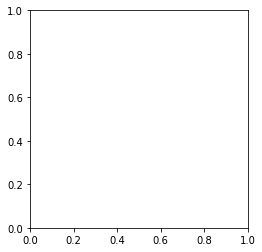

In [38]:
plt.imshow(src)

# Other Distortions

In [52]:
def generatePicture():
    beats = random.choices([3,4],weights=[0.25,0.75], k=1)[0]
    count = random.choices([1,2,3,4,5],weights=[1,1,1,1,1], k=1)[0]
    track = NewTrack(beats,count,withChromatics=False,with16=False)
    track_string = LilyPond.from_Track(track)
    track_string_clean = CleanTrack(track_string)
    GenerateCropped(track_string_clean,"tmp_track")
    imgConvert("tmp_track.preview.png", "tmp_track.jpg")
    src   = cv2.imread('tmp_track.jpg')
    src    = src[...,::-1] # BGR to RGB
    return src

## Blur

In [39]:
pic = generatePicture()
plt.imshow(pic)

NameError: name 'generatePicture' is not defined

In [40]:
img_blur = cv2.blur(pic,(7,7))
plt.imshow(img_blur)

NameError: name 'pic' is not defined

In [ ]:
plt.imshow(img_blur)
im = Image.fromarray(img_blur)
im.save("blurre.jpg")

In [41]:
img_blur.dtype

NameError: name 'img_blur' is not defined

In [ ]:
for kernel in range(3,11,2):
    for sigma in range(0,4):
        gaussian_blur = cv2.GaussianBlur(pic,(kernel,kernel), sigmaX=sigma)
        plt.imshow(gaussian_blur)
        im_gaus = Image.fromarray(gaussian_blur)
        im_gaus.save(f"gauss_blur{kernel}-{sigma}.jpg")

## Noise

In [42]:
for mean in range(60,160,20):
    for sigma in range(40,80,10):
        gauss = np.random.normal(mean,sigma,(pic.shape))
        #noisy_gauss = np.clip(pic + gauss,0,255).astype(np.uint8)
        noisy_image = pic + gauss
        cv2.normalize(noisy_image, noisy_image, 0, 255, cv2.NORM_MINMAX, dtype=-1)
        noisy_image = noisy_image.astype(np.uint8)
        im = Image.fromarray(noisy_image)

        im.save(f"noisy_gauss{mean}_{sigma}.jpg")
        

NameError: name 'pic' is not defined

In [43]:
noisy = skimage.util.random_noise(pic, mean=0.2)
noisy = np.clip(noisy*255,0,255).astype(np.uint8)

NameError: name 'skimage' is not defined

In [ ]:
plt.imshow(noisy)
im = Image.fromarray(noisy)
im.save(f"noisy_skimage2.jpg")

In [44]:
plt.imshow(noisy_gauss)

NameError: name 'noisy_gauss' is not defined

In [ ]:
for i in range(0,10):
    m = i/10
    for j in range(1,20,4):
        v = j/100
        noisy_image = skimage.util.random_noise(pic, mean = m, var= v)
        noisy_image = np.clip(noisy_image*255,0,255).astype(np.uint8)
        im = Image.fromarray(noisy_image)
        im.save(f"noisy_skimage{m}_{v}.jpg")
        

## Elastic

In [45]:
import numpy as np
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter

def elastic_transform(image, alpha, sigma, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_.
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
       Convolutional Neural Networks applied to Visual Document Analysis", in
       Proc. of the International Conference on Document Analysis and
       Recognition, 2003.
    """
    assert len(image.shape)==2

    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape

    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha

    x, y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), indexing='ij')
    indices = np.reshape(x, (-1, 1)), np.reshape(y+dy, (-1, 1))
    
    return map_coordinates(image, indices, order=1).reshape(shape)

In [46]:
elastic = np.zeros(pic.shape)
for i in range(0,3):
    elastic[:,:,i]= elastic_transform(pic[:,:,i], 200,200,np.random.RandomState(5))
    
plt.imshow(elastic)

NameError: name 'pic' is not defined

In [ ]:
elastic = np.clip(elastic*255,0,255).astype(np.uint8)
im_elastic = Image.fromarray(elastic)
im_elastic.save("elastic.jpg")

# Combined

In [ ]:
def imgConvert(from_name, to_name):
    im = Image.open(from_name)
    rgb_im = im.convert('RGB')
    rgb_im.save(to_name)

In [84]:
def CleanTrack(track):
    delete_clef_string = " \n \override Staff.Clef.color = #white \n \override Staff.Clef.layer = #-1"
    delete_time_string = " \n \override Staff.TimeSignature.color = #white \n \override Staff.TimeSignature.layer = #-1"
    track = track[0] + delete_clef_string + delete_time_string+ track[1:]
    return track

In [492]:
def handle_single_track():
    beats = random.choices([3,4],weights=[0.25,0.75], k=1)[0]
    count = random.choices([1,2,3,4,5],weights=[1,1,1,1,1], k=1)[0]
    image_track, ground_track = GenSingleLily(beats,count,withChrom=False,with16=True)
    GenerateCropped(image_track, "temp_to_split")
    src = cv2.imread("temp_to_split.preview.png")
    src    = src[...,::-1] # BGR to RGB
    src = randomWarpImage(src)
    #im = Image.fromarray(src)
    #plt.imshow(src)
    H, W, Nc = src.shape
    src = src[:,170:,:]
    return ground_track, image_track, src

In [430]:
import random

def handle_multi_track():
    beats = random.choices([3,4],weights=[0.25,0.75], k=1)[0]
    count = random.choices([1,2,3,4,5],weights=[1,1,1,1,1], k=1)[0]
    image_track, ground_track = GenTripleLily(beats,count,withChrom=False,with16=True)
    GenerateCropped(image_track, "temp_to_split")
    src = cv2.imread("temp_to_split.preview.png")
    src    = src[...,::-1] # BGR to RGB
    src = randomWarpImage(src)
    #im = Image.fromarray(src)
    #plt.imshow(src)
    H, W, Nc = src.shape
    r = random.random()
    if r <0.33:
        src = src[:H//3,:,:]
    elif r < 0.66:
        src = src[H//3:2*H//3,:,:]
    else :
        src = src[2*H//3:,:,:]
    src = src[:,170:,:]
    return ground_track, image_track, src

Executing: lilypond -dresolution=300 -dpreview -fpng -o "temp_to_split" "temp_to_split.ly"
(350, 1476, 3)


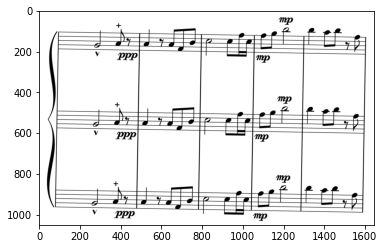

In [431]:
ground, image_track, src = handle_multi_track()
print(src.shape)

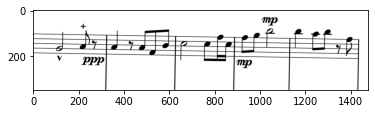

In [432]:
im = Image.fromarray(src)
plt.imshow(src)

In [396]:
def randomWarpImage(src,x_range=4,y_range=10,z_range=10):
    x_angle = int(random.uniform(-x_range,x_range))
    y_angle = int(random.uniform(-y_range,y_range))
    z_angle = int(random.uniform(-z_range,z_range))
    fov = int(random.uniform(30,50))
    warped_image = warpImage(src,x_angle,y_angle,z_angle,1,fov)
    return warped_image[:,:,:]

In [446]:
def randomBlurImage(src, kernel=7, sigma_min=0, sigma_max = 3):
    sigma = random.randint(sigma_min,sigma_max)
    gaussian_blur = cv2.GaussianBlur(src,(kernel,kernel), sigmaX=sigma)
    return gaussian_blur

In [453]:
import skimage
def randomNoise(src, mean_min = 3, mean_max = 5, var_min = 1, var_max=9):
    m = random.randint(mean_min,mean_max)/10
    v = random.randint(var_min,var_max)/100
    noisy_image = skimage.util.random_noise(src, mean = m, var= v)
    noisy_image = np.clip(noisy_image*255,0,255).astype(np.uint8)
    return noisy_image
            

In [454]:
def addRandomDist(src):
    if random.random() < 0.33:
        src = randomBlurImage(src)
    if random.random() < 0.33:
        src = randomNoise(src)
    return src

In [525]:
def adaptLilyForModel(lp):
    new_lilypond = lp.replace("{ {", "").replace("} {","|").replace("} }","|")
    return new_lilypond

In [526]:
import os
def GenerateRandomPhoto(name, data_dir_path = "./Data"):
    if random.random() <= 0.25:
        ground_track , image_track, src = handle_single_track()
    else:
        ground_track , image_track, src = handle_multi_track()
    src = addRandomDist(src)
    ground_track = ground_track.replace("{ {", "").replace("} {","|").replace("} }","|")
    im = Image.fromarray(src)
    os.mkdir(f"{data_dir_path}/{name}")
    im.save(f"{data_dir_path}/{name}/{name}.jpg")
    with open(f"{data_dir_path}/{name}/{name}.txt", "w") as text_file:
        text_file.write(ground_track)


Executing: lilypond -dresolution=300 -dpreview -fpng -o "temp_to_split" "temp_to_split.ly"


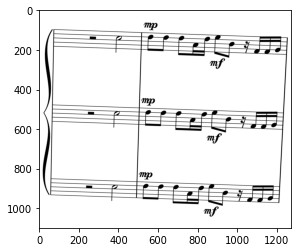

In [527]:
GenerateRandomPhoto("Stringtext")

Executing: lilypond -dresolution=300 -dpreview -fpng -o "temp_to_split" "temp_to_split.ly"


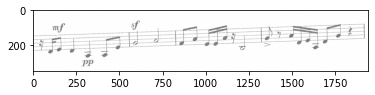

In [523]:
if random.random() <= 0.25:
    ground_track , image_track, src = handle_single_track()
else:
    ground_track , image_track, src = handle_multi_track()
src = addRandomDist(src)
im = Image.fromarray(src)
plt.imshow(im)
im.save("line.jpg")

In [529]:
d = {}
for i in range(100):
    count = random.randint(0,10)
    print(count)

8
2
10
4
7
4
0
8
0
6
0
8
3
6
5
0
9
5
8
1
10
4
5
9
10
3
10
10
3
2
4
2
0
10
3
2
9
8
5
3
7
3
8
9
6
1
3
9
3
1
3
4
2
9
0
1
6
8
5
4
6
9
9
1
10
3
7
2
9
3
1
7
6
4
5
4
10
6
6
4
6
5
10
10
5
3
3
0
2
4
2
1
4
9
8
0
8
0
10
7
